# Assignment 2 - Interplanetary Transfer

For this assignment, you will use a Lambert targeter to generate a first guess for an unperturbed interplanetary transfer. Subsequently, you will use various numerical propagation models that include perturbations to analyze the trajectory in more detail, and compute trajectory corrections such that your trajectory meets its boundary conditions (departure and arrival) in the perturbed environment,

In this assignment, you are required to modify this Jupyter notebook. Unlike assignment 1, this assignment is in a single notebook, with the code for all questions and the assignment description all merged into a single document.


**General Instructions**

In this assignment, you will use a so-called Lambert targeter (a tool that solves Lambert's problem) to generate an initial guess for an interplanetary direct high-thrust transfer. The Lambert targeter takes as input:

<ul>
    <li>A departure position $\mathbf{r}_0$</li>
    <li>An arrival position $\mathbf{r}_E$</li>
    <li>A time of flight $T$</li>
    <li>A central body gravitational parameter $\mu$</li>
</ul>


The Lambert targeter then generates the Keplerian trajectory between $\mathbf{r}_{0}$ and $\mathbf{r}_{E}$, with the given time of flight $T$. Since the initial and final positions uniquely define the trajectory (assuming a prograde single-revolution trajectory; ignoring rare singular cases), the full state along this Keplerian trajectory (or Lambert arc) are *outputs* of the Lambert targeter. We denote the Cartesian state function of this Lambert arc as $\bar{\mathbf{x}}(t)$. For your situation, the initial and final position $\mathbf{r}_{0}$ and $\mathbf{r}_{E}$ of the full trajectory are the positions of the center of mass of Earth and Mars or Venus (w.r.t. the Sun), at times $t_{0}$ and $t_{E}$, respectively (with values depending on your student number, to be found in the $\texttt{assignment2Input-2020-2021.txt}$ file on Brightspace under Assignment 2).

All analysis on the output data can be done in the notebook. However, if you would like to use a different piece of software (*e.g.* Matlab) for your analyses, the relevant data is provided as output to data files, in a number of manners:

* By calling the `propagate_trajectory` function, the propagated state of the spacecraft and the associated dependent variables will be saved to a file, as well as the state of the Lambert arc $\bar{\mathbf{x}}$ at the epochs of the numerical integration. See the in-code comments of the `write_propagation_results_to_file` function in the helper functions block code file for more details.
* For question 3, the `write_propagation_results_to_file` function is called directly from the $\texttt{main}$ function.


**Before starting the assignment, read the submission instructions given at the end of this notebook.**




In [4]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import estimation_setup
from tudatpy.kernel.simulation import propagation_setup
from tudatpy.kernel.astro import two_body_dynamics
from tudatpy.kernel.astro import conversion
from matplotlib import pyplot as plt
import matplotlib

# STUDENT CODE TASK (fill in ...)
departure_epoch = 1525.268138 * constants.JULIAN_DAY
time_of_flight = 178.6872795 * constants.JULIAN_DAY
arrival_epoch = departure_epoch + time_of_flight
target_body = "Venus"

# Global settings
fixed_step_size = 3600   #3600
global_frame_origin = "SSB"
global_frame_orientation = "ECLIPJ2000"

# Helper variables for question 4
current_question = 0;
rsw_acceleration_magnitude = [0,0,0]

# Load spice kernels.
spice_interface.load_standard_kernels()

# Set output directory
output_directory = "./SimulationOutput/"

# Helper Functions (DO NOT MODIFY)

In [5]:
def write_propagation_results_to_file( dynamics_simulator, lambert_arc_state_model, file_output_identifier, output_directory):

    """
    This function will write the results of a numerical propagation, as well as the Lambert arc states at the epochs of the
    numerical state history, to a set of files. Two files are always written when calling this function (numerical state history, a
    and Lambert arc state history). If any dependent variables are saved during the propagation, those are also saved to a file
    
    Parameters
    ----------
    dynamics_simulator : Object that was used to propagate the dynamics, and which contains the numerical state and dependent
                         variable results
       
    lambert_arc_state_model : Lambert arc state model as returned by the get_lambert_problem_result() function
    
    file_output_identifier : Name that will be used to correctly save the output data files
    
    output_directory : Directory to which the files will be written
    
    Files written
    -------------
    
    <output_directory/file_output_identifier>_numerical_states.dat
    <output_directory/file_output_identifier>_dependent_variables.dat
    <output_directory/file_output_identifier>_lambert_statess.dat

    
    Return
    ------
    None
    
    """
        
    # Save numerical states
    simulation_result = dynamics_simulator.state_history
    save2txt(solution= simulation_result, filename=output_directory + file_output_identifier + "_numerical_states.dat", directory="./", column_names=None )
   
    # Save dependent variables
    dependent_variables = dynamics_simulator.dependent_variable_history
    if len(dependent_variables.keys()) > 0:
        save2txt(solution= dependent_variables, filename=output_directory + file_output_identifier + "_dependent_variables.dat", directory="./", column_names=None )
   
    # Save Lambert arc states
    lambert_arc_states = get_lambert_arc_history( lambert_arc_state_model, simulation_result )
    
    save2txt(solution= lambert_arc_states, filename= output_directory + file_output_identifier + "_lambert_states.dat",  directory="./", column_names=None )
    
    return

def get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch):
    
    # Gravitational parameter of the Sun
    central_body_gravitational_parameter = bodies.get_body( "Sun" ).gravitational_parameter
    
    # Set initial and final positions for Lambert targeter
    initial_state = spice_interface.get_body_cartesian_state_at_epoch(
       target_body_name="Earth",
       observer_body_name="Sun",
       reference_frame_name=global_frame_orientation,
       aberration_corrections="NONE",
       ephemeris_time= departure_epoch )
    
    final_state = spice_interface.get_body_cartesian_state_at_epoch(
       target_body_name= target_body,
       observer_body_name="Sun",
       reference_frame_name=global_frame_orientation,
       aberration_corrections="NONE",
       ephemeris_time= arrival_epoch )
    
    # Create Lambert targeter
    lambertTargeter = two_body_dynamics.LambertTargeterIzzo(
                initial_state[:3], final_state[:3],arrival_epoch - departure_epoch, central_body_gravitational_parameter );
    
    # Compute initial Cartesian state of Lambert arc
    lambert_arc_initial_state = initial_state
    lambert_arc_initial_state[3:] = lambertTargeter.get_departure_velocity()
    
    # Compute Keplerian state of Lambert arc
    lambert_arc_keplerian_elements = conversion.cartesian_to_keplerian( lambert_arc_initial_state, 
                                                                  central_body_gravitational_parameter)
    
    # Setup Keplerian ephemeris model that describes the Lambert arc
    kepler_ephemeris = environment_setup.create_body_ephemeris(
        environment_setup.ephemeris.keplerian( lambert_arc_keplerian_elements, departure_epoch, central_body_gravitational_parameter ), "" )
   
    return kepler_ephemeris

def get_lambert_arc_history( lambert_arc_state_model, simulation_result ):
    
    lambert_arc_states = dict()
    for state in simulation_result:
        lambert_arc_states[ state ] = lambert_arc_state_model.get_cartesian_state( state )
        
    return lambert_arc_states


def propagate_trajectory( initial_time, final_time, bodies, lambert_arc_state_model, 
                          file_output_identifier, use_perturbations, initial_state_correction=[0,0,0,0,0,0]):
    
    """
    This function will be repeatedly called throughout the assignment. Propagates the trajectory based 
    on several input parameters, and subsequently saves the results to data files.
    
    Parameters
    ----------
    initial_time : Epoch since J2000 at which the propagation starts
    
    final_time : Epoch since J2000 at which the propagation will be terminated
    
    lambert_arc_state_model : Lambert arc state model as returned by the get_lambert_problem_result() function
    
    file_output_identifier : Name that will be used to correctly save the output data files
    
    use_perturbations : Boolean to indicate whether a perturbed (True) or unperturbed (False) trajectory 
                        is propagated
                        
    initial_state_correction : (optional) Cartesian state which is added to the Lambert arc state when computing the numerical initial state
    
    Return
    ------
    Dynamics simulator object from which the state- and dependent variable history can be extracted
    
    """
    
    # Compute initial state along Lambert arc (and apply correction if needed)
    lambert_arc_initial_state = lambert_arc_state_model.get_cartesian_state( initial_time ) + initial_state_correction

    # Get propagator settings for perturbed/unperturbed forwards/backwards arcs
    if use_perturbations:
        propagator_settings = get_perturbed_propagator_settings( bodies, lambert_arc_initial_state, final_time )
    else:
        propagator_settings = get_unperturbed_propagator_settings( bodies, lambert_arc_initial_state, final_time )
           
    # If propagation is backwards in time, make initial time step negative
    if initial_time > final_time:
        signed_fixed_step_size = -fixed_step_size
    else:
        signed_fixed_step_size = fixed_step_size
        
    # Create numerical integrator settings
    integrator_settings = propagation_setup.integrator.runge_kutta_4( initial_time, signed_fixed_step_size )
    
    # Propagate forward/backward perturbed/unperturbed arc and save results to files
    dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(bodies, integrator_settings, propagator_settings, True)
    write_propagation_results_to_file( dynamics_simulator, lambert_arc_state_model, file_output_identifier, output_directory)

    return dynamics_simulator
  
def propagate_variational_equations(initial_time, final_time, bodies, lambert_arc_state_model):
    
    """
    Propagates the variational equations for a given range of epochs for a perturbed trajectory.
    
    Parameters
    ----------
    initial_time : Epoch since J2000 at which the propagation starts
    
    final_time : Epoch since J2000 at which the propagation will be terminated
    
    bodies : Body objects as returned by creates_simulation_bodies() function
    
    lambert_arc_state_model : Lambert arc state model as returned by the get_lambert_problem_result() function
    
    Return
    ------
    Variational equations solver object, from which the state-, state transition matrix-, and 
    sensitivity matrix history can be extracted.
    """
    
    # Compute initial state along Lambert arc
    lambert_arc_initial_state = lambert_arc_state_model.get_cartesian_state( initial_time )

    # Get propagator settings
    propagator_settings = get_perturbed_propagator_settings(bodies, lambert_arc_initial_state, final_time)
    
    # Get integrator settings       
    integrator_settings = propagation_setup.integrator.runge_kutta_4(
        initial_time, fixed_step_size )
    
    # Define parameters for variational equations
    sensitivity_parameters = get_sensitivity_parameter_set( propagator_settings, bodies, target_body)  
    
    # Propagate variational equations
    variational_equations_solver = estimation_setup.SingleArcVariationalEquationsSolver(
         bodies, integrator_settings, propagator_settings, sensitivity_parameters,integrate_on_creation=1 )
    
    return variational_equations_solver

def get_sensitivity_parameter_set(propagator_settings, bodies, target_body):

    parameter_settings = estimation_setup.parameter.initial_states(
        propagator_settings, bodies )
    if current_question == 4:
        parameter_settings.append( estimation_setup.parameter.constant_empirical_acceleration_terms ("Spacecraft", "Sun" ) )    
    
    return estimation_setup.create_parameters_to_estimate(parameter_settings, bodies, propagator_settings)

# Helper Functions (TO BE MODIFIED)

In [6]:
# STUDENT CODE TASK - define function such that it provides propagator settings as per question 1
def get_unperturbed_propagator_settings(bodies, initial_state, termination_time):
    
    """
    Creates the propagator settings for an unperturbed trajectory.

    Parameters
    ----------
    bodies : Body objects as returned by creates_simulation_bodies() function 
        
    initial_state : Cartesian initial state of the vehicle in the simulation
        
    termination_time : Epoch since J2000 at which the propagation will be terminated
        

    Return
    ------
    Propagation settings of the unperturbed trajectory.
    """
     
 
    # Create propagation settings with termination time.
    bodies_to_propagate = ["Spacecraft"]
    central_bodies = ["Sun"] 
    acceleration_settings_on_spacecraft = dict(
        Sun = [propagation_setup.acceleration.point_mass_gravity()]
    )

    # Create global accelerations dictionary.
    acceleration_settings = {"Spacecraft": acceleration_settings_on_spacecraft}

    # Create acceleration models.
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies)
    
    system_initial_state = initial_state
    simulation_end_epoch = termination_time
    dependent_variables_to_save = [propagation_setup.dependent_variable.keplerian_state("Spacecraft", "Sun")]
    
    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        system_initial_state,
        simulation_end_epoch,
        output_variables = dependent_variables_to_save)
    
    
    return propagator_settings

# STUDENT CODE TASK - define function such that it provides propagator settings as per question 2-5
def get_perturbed_propagator_settings(bodies, initial_state, termination_time):
    
    """
    Creates the propagator settings for a perturbed trajectory.

    Parameters
    ----------
    bodies : Body objects as returned by creates_simulation_bodies() function 
        
    initial_state : Cartesian initial state of the vehicle in the simulation
        
    termination_time : Epoch since J2000 at which the propagation will be terminated
        

    Return
    ------
    Propagation settings of the perturbed trajectory.
    """
    bodies_to_propagate = ["Spacecraft"]
    central_bodies = ["Sun"]    

    # Define accelerations acting on vehicle. 
    acceleration_settings_on_spacecraft = dict(
        Sun     = [propagation_setup.acceleration.point_mass_gravity(),
                   propagation_setup.acceleration.cannonball_radiation_pressure()],
        Venus   = [propagation_setup.acceleration.point_mass_gravity()],
        Moon    = [propagation_setup.acceleration.point_mass_gravity()],
        Earth   = [propagation_setup.acceleration.point_mass_gravity()],
        Mars    = [propagation_setup.acceleration.point_mass_gravity()],
        Jupiter = [propagation_setup.acceleration.point_mass_gravity()],
        Saturn  = [propagation_setup.acceleration.point_mass_gravity()]
        )
    
    # DO NOT MODIFY (line is added for compatibility with question 4)
    if current_question == 4:
        acceleration_settings_on_spacecraft[ "Sun" ].append( propagation_setup.acceleration.empirical( rsw_acceleration_magnitude ) )

    # Create acceleration models.
    acceleration_settings = {"Spacecraft": acceleration_settings_on_spacecraft}
    acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies)
    

    # Create propagation settings.
    system_initial_state = initial_state
    simulation_end_epoch = termination_time
    
    dependent_variables_to_save = [propagation_setup.dependent_variable.total_acceleration("Spacecraft")]
    

    propagator_settings = propagation_setup.propagator.translational(
        central_bodies,
        acceleration_models,
        bodies_to_propagate,
        system_initial_state,
        simulation_end_epoch,
        output_variables = dependent_variables_to_save)
    
    return propagator_settings

# STUDENT CODE TASK - define function such that it creates the bodies needed for the simulation
def create_simulation_bodies( ):
    
    """
    Creates the body objects required for the simulation.
    Vehicle interfaces, such as the radiation pressure interface, will be defined here.

    Parameters
    ----------
    none

    Return
    ------
    Body objects required for the simulation.
    
    """
    bodies_to_create = ['Sun', 'Venus', 'Moon', 'Earth', 'Mars', 'Jupiter', 'Saturn'] 
    body_settings = environment_setup.get_default_body_settings(
        bodies_to_create, global_frame_origin, global_frame_orientation)    
    bodies = environment_setup.create_system_of_bodies(body_settings)   
    
    bodies.create_empty_body( "Spacecraft" )
    bodies.get_body( 'Spacecraft' ).set_constant_mass(1000.0)
    
    #canonball radiation
    reference_area_radiation = 20.0
    radiation_pressure_coefficient = 1.2
    radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
                "Sun", reference_area_radiation, radiation_pressure_coefficient)
    environment_setup.add_radiation_pressure_interface(
                    bodies, "Spacecraft", radiation_pressure_settings)
    
    
    return bodies;

       

# Question 1 
### 10 points; Maximum text length: 10 lines

Use the Lambert arc's initial state $\bar{\mathbf{x}}(t_{0})$ as initial state for the numerical propagation (spacecraft w.r.t. Sun), with the given initial time $t_{0}$. Run the code to propagate the state of the spacecraft using only the Sun's point-mass attraction, with the Sun as propagation origin. 
<ul>
    <li> Plot the total trajectory in three dimensions. </li>
    <li> Plot the difference between the Lambert targeter result $\bar{\mathbf{x}}(t)$ and the numerical propagation ${\mathbf{x}}(t)$. Specifically, plot the difference in each of the three Cartesian position components of the spacecraft w.r.t. the Sun.</li>
</ul>
    

<style type="text/css">
    ol { list-style-type: upper-alpha; }
</style>

**Answer the following questions:**

**a)** Discuss whether the mathematical model solved numerically in this question is an *exact* representation of the Lambert arc model. In your discussion, add a comprehensive list of the assumptions of the Lambert arc model, and briefly explain for each one why it is (not) true in your propagation. If needed, back up your argumentation by adding, and plotting, any additional dependent variables to the simulation output you see fit.

**b)** If you concluded under (a) that the formulations are physically identical, what is the source of any differences you observe between the numerical result and the Lambert result? If you concluded that they are not identical, is any difference you observe relevant for your results?

**Add to save file 1**: <br>
Row 1: initial propagation time and Cartesian state. <br>
Row 2: final propagation time and Cartesian state.

**Coding instructions and hints**

The code block below propagates the dynamics for *unperturbed* dynamics, with the initial state extracted directly from the Lambert arc. The resulting numerical state history ($\mathbf{x}(t)$) is stored in the `state_history` variable. The state history, as computed directly from the Lambert arc ($\bar{\mathbf{x}}(t)$) is stored directly in the `lambert_history` variable.

To make this function generate results, you have a **Code task** for the following helper functions:

* `create_simulation_bodies`: this function defines the body settings and creates the body objects
* `get_unperturbed_propagator_settings`: this function defines the propagator settings for the unperturbed case

In order to ensure compatibility with the rest of the code, call your vehicle:** `"Spacecraft"`. 

In [132]:
###########################################################################
# RUN CODE FOR QUESTION 1 #################################################
###########################################################################

current_question = 1

# Create body objects
bodies = create_simulation_bodies( )

# Create Lambert arc state model
lambert_arc_state_model = get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch)

# Create propagation settings and propagate dynamics
dynamics_simulator = propagate_trajectory(departure_epoch, arrival_epoch, bodies, lambert_arc_state_model, 
                     "Q1", use_perturbations = False)

# Extract state history from dynamics simulator
state_history = dynamics_simulator.state_history

# Evaluate the Lambert arc model at each of the epochs in the state_history variable
lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history )



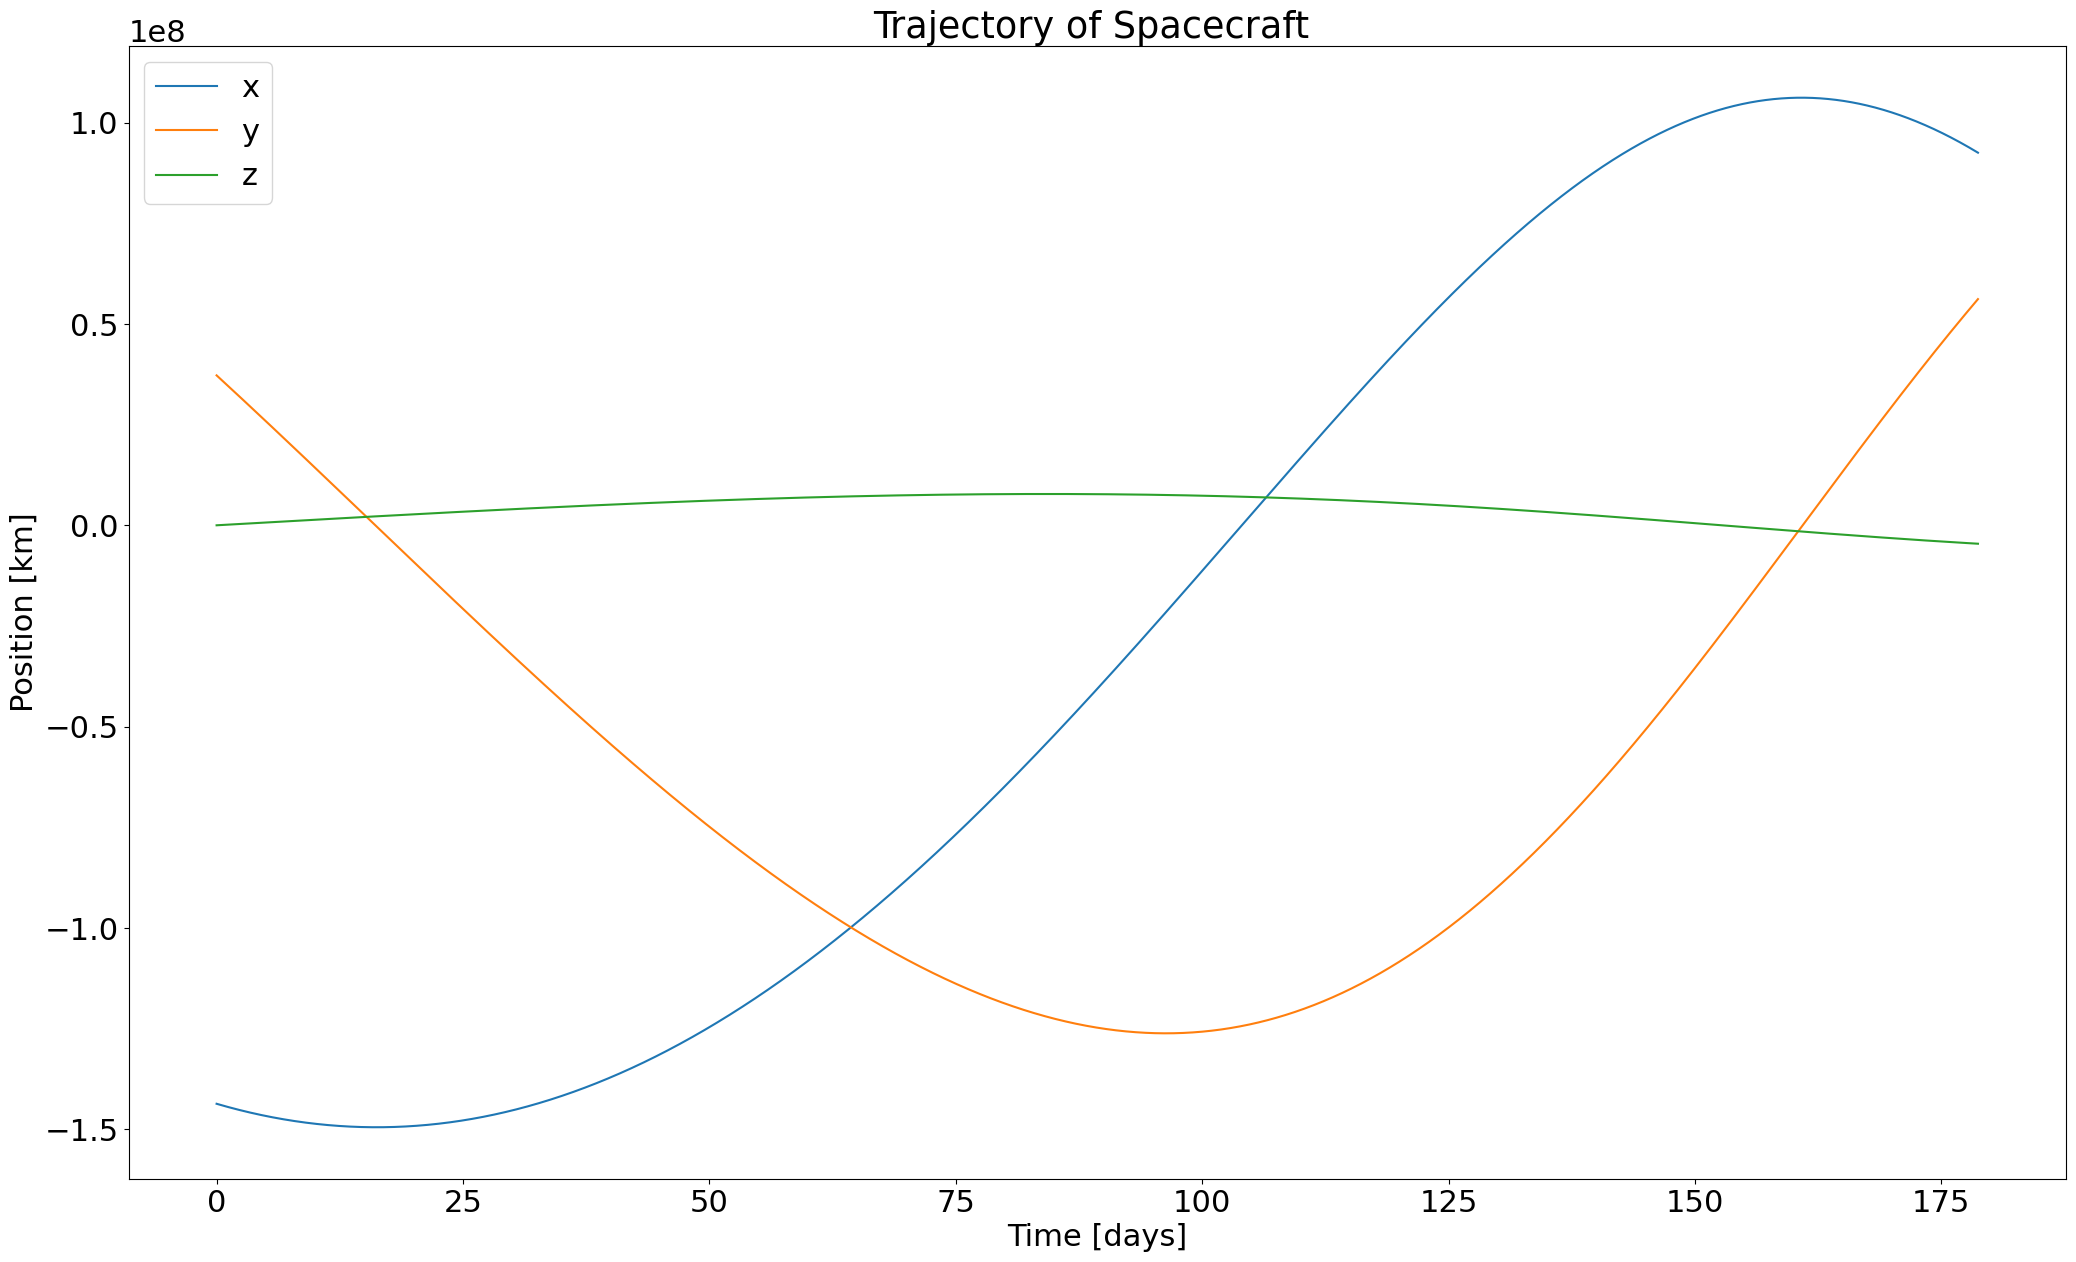

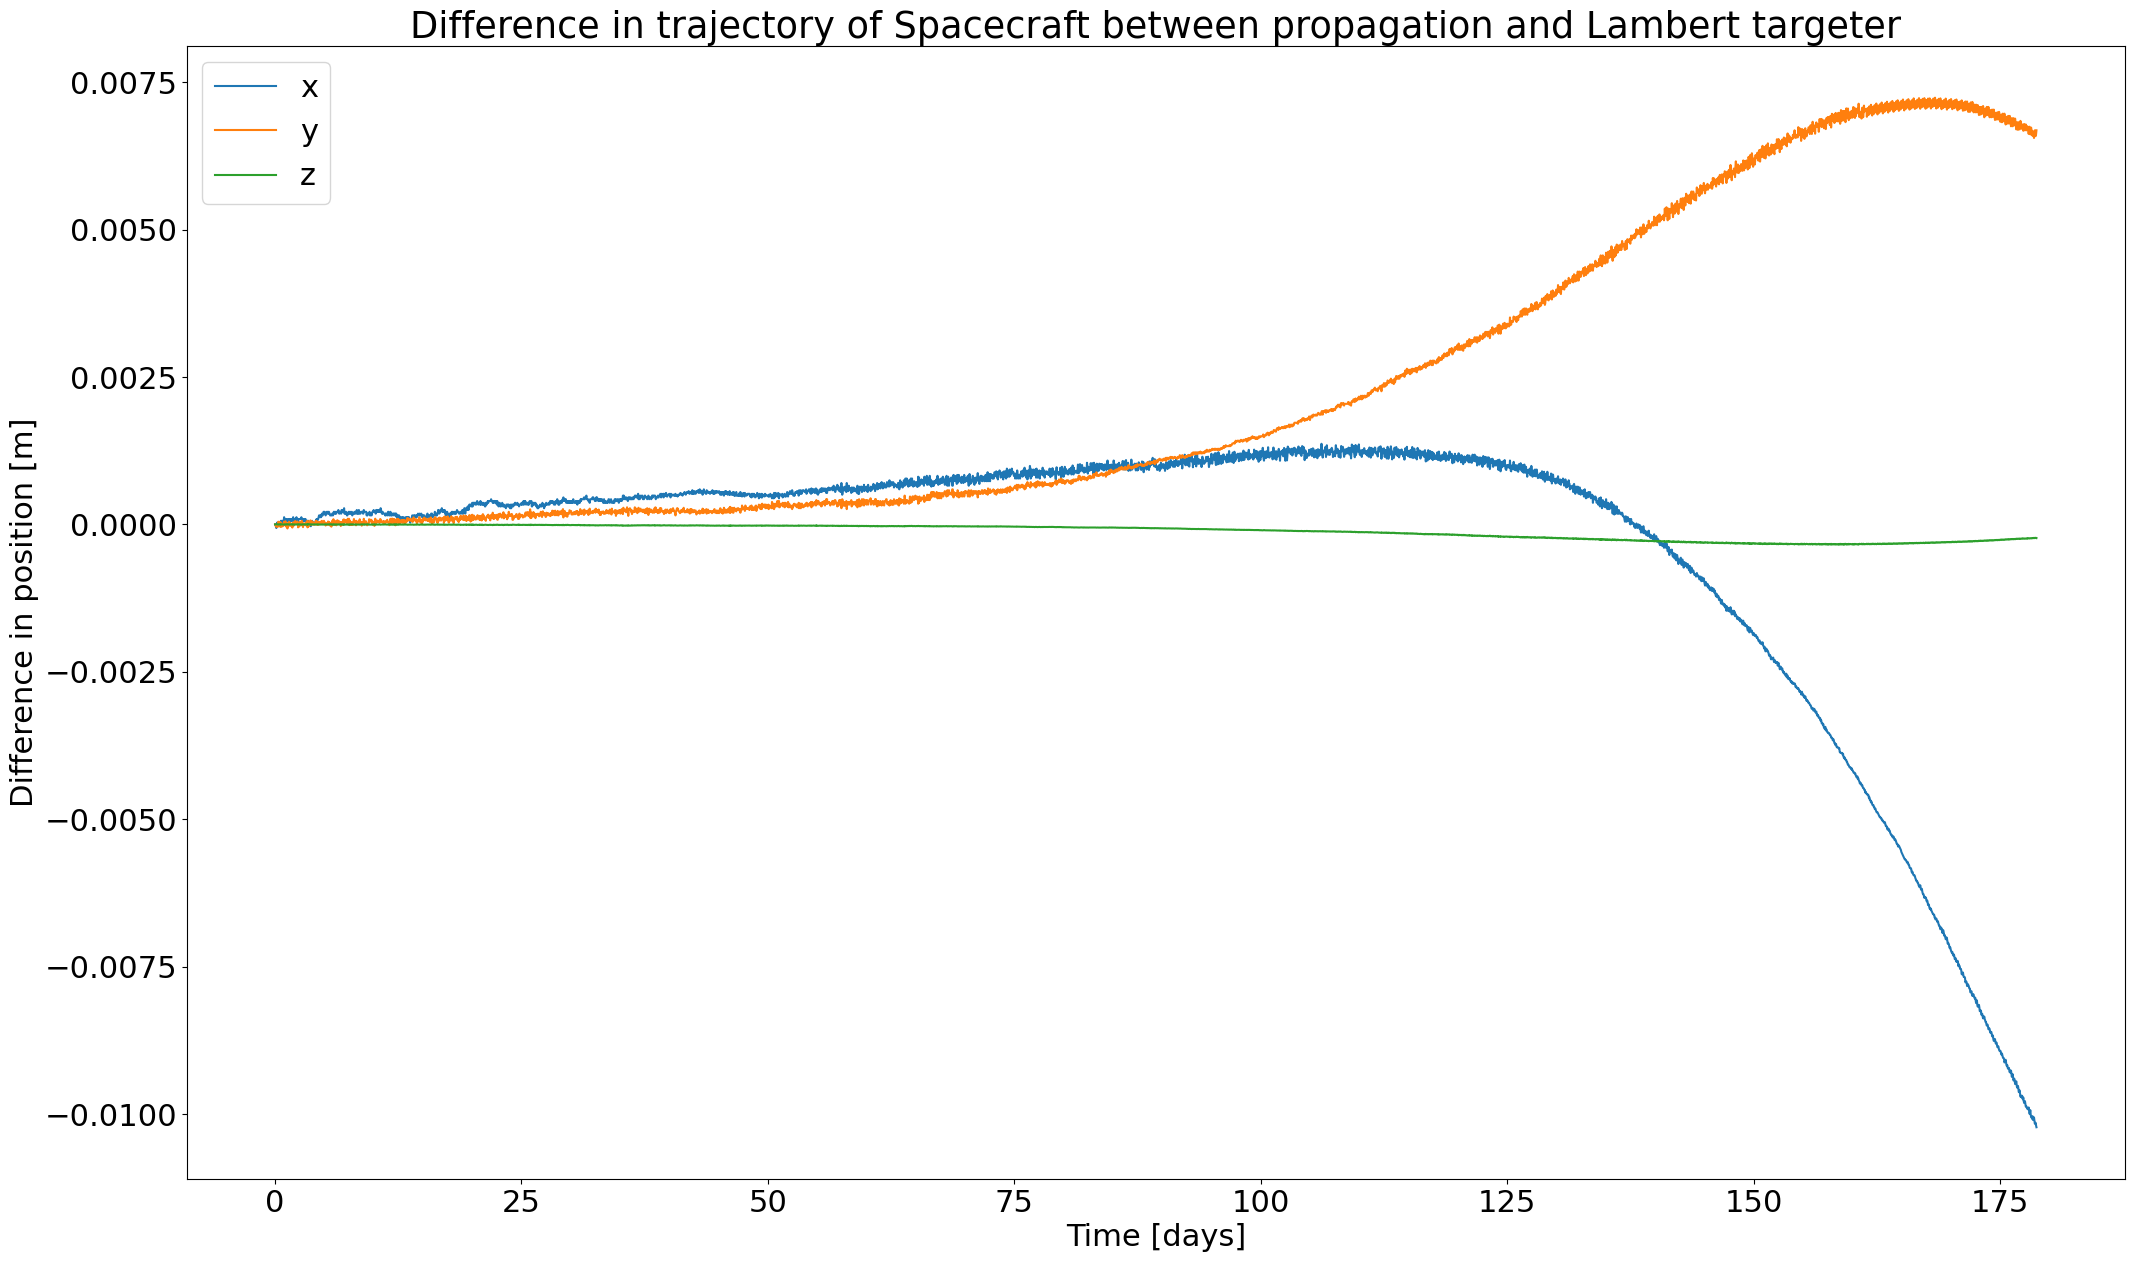

In [133]:
time = state_history.keys()
time_days = [ t/ constants.JULIAN_DAY - departure_epoch/ constants.JULIAN_DAY for t in time ]

x      = []
y      = []
z      = []
x_diff = []
y_diff = []
z_diff = []
for t in time:
    x.append(state_history[t][0]*10**-3)
    y.append(state_history[t][1]*10**-3)
    z.append(state_history[t][2]*10**-3)
    x_diff.append(state_history[t][0] - lambert_history[t][0])
    y_diff.append(state_history[t][1] - lambert_history[t][1])
    z_diff.append(state_history[t][2] - lambert_history[t][2])

fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 22})

plt.plot(time_days, x, label = 'x')
plt.plot(time_days, y, label = 'y')
plt.plot(time_days, z, label = 'z')
plt.title('Trajectory of Spacecraft ')
plt.ylabel('Position [km]')
plt.xlabel('Time [days]')
plt.legend()
plt.savefig("Q1_position.png")
#plt.show()

fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 22})
    
plt.plot(time_days, x_diff, label = 'x')
plt.plot(time_days, y_diff, label = 'y')
plt.plot(time_days, z_diff, label = 'z')
plt.title('Difference in trajectory of Spacecraft between propagation and Lambert targeter')
plt.ylabel('Difference in position [m]')
plt.xlabel('Time [days]')
plt.legend()
plt.savefig('Q1_difference.png')
#plt.show()



# Question 2 
### 20 points; Maximum text length: 15 lines

Now add the following perturbations to the numerical propagation (by modifying the `get_perturbed_propagation_settings` and the `create_simulation_bodies` functions):

<ul>
    <li> Point-mass gravity by Venus, Earth, Moon, Mars, Jupiter, Saturn and Sun </li>
    <li> Cannonball radiation pressure on spacecraft. Use a reference area of 20 m$^2$, a radiation pressure coefficient of 1.2, and a vehicle mass of 1000 kg. </li>
</ul>

To do so, also update the definition of the environment (modify the `create_simulation_bodies` function) so that these accelerations can be evaluated

Run the propagation with$^2$:<br>
i) The initial and final propagation time equal to the initial and final times of the Lambert arc. <br>
ii) The initial and final propagation time shifted forward and backward in time, respectively, by $\Delta t=$1 hour. <br>
iii) The initial and final propagation time shifted forward and backward in time, respectively, by $\Delta t=$2 days.

    
Note that if you shift the initial time from $t_{0}$ to $t_{0}+\Delta t$ (by modifying these inputs to the `propagate_trajectory` function), the initial state used for the propagation will be adjusted (automatically) accordingly to $\mathbf{\bar{x}}(t_{0}+\Delta t)$. 

For each propagation, plot the quantities $\Delta r=||\mathbf{r}(t)-\bar{\mathbf{r}}(t)||$, $\Delta v=||\mathbf{v}(t)-\bar{\mathbf{v}}(t)||$ and $\Delta a=||\mathbf{a}(t)-\bar{\mathbf{a}}(t)||$ as a function of time. **Note** The quantity $\bar{\mathbf{a}}(t)$ is not provided automatically, compute its value at each step manually from $\frac{-\mu}{r^{3}}\mathbf{r}$.

**Answer the following questions:**

**a)** For each of the cases (i)-(iii), find the maxima of each of the quantities $\Delta r$, $\Delta v$ and $\Delta a$, and the times at which they occur. Provide a table with the following for each of the cases (i)-(iii): the maximum values of these three quantities, and the times at which they reach their maxima. Write these times *as a fraction of the total propagation time.* Note that a visual determination of the required quantities from the plots you make is sufficient for the purposes of this question.
    
**b)** Redo the propagation for case (ii), but now propagating forward and backward from the middle point (in time) of the propagation. Plot the quantities quantities $\Delta r$, $\Delta v$ and $\Delta a$, and extend the table you made in question (a) with the results of this question. Consider the forward and backward propagation separately. *Note: the* `propagate_trajectory` *function will automatically propagate backwards in time if the initial time is larger than the final time.*
    
**c)** Analytically derive formulations for $\frac{d}{dt}(\Delta r)$ and $\frac{d}{dt}(\Delta v)$. These quantities are a measure for how quickly the numerical solution diverges from the Lambert arc solution. In your derivations, use only the following quantities:

<ul>
<li> Positions and velocities along the propagated orbit $\mathbf{r}$, $\mathbf{v}$
<li> Positions and velocities along the Lambert arc $\bar{\mathbf{r}}$, $\bar{\mathbf{v}}$
<li> Total accelerations in the Lambert model  $\bar{\mathbf{a}}$
<li> The acceleration components $\mathbf{a}_{\text{Sun}}$ and $\mathbf{a}_{\text{pert}}$ of the propagated orbit.
</ul>
In the above, we have used (for the numerical model) the shorthand $\mathbf{a}_{\text{Sun}}(t)$ for the Sun's gravitational acceleration, and have lumped all additional accelerations  into $\mathbf{a}_{\text{pert}}$, so that the total acceleration acting on the spacecraft is given by $\left(\mathbf{a}_{p}\right)_{S}(t)=\mathbf{a}_{\text{Sun}}(t)+\mathbf{a}_{\text{pert}}(t)$. 

**Hint**: Use the relation $\dfrac{d||\mathbf{b}||}{d\mathbf{b}}=\dfrac{\mathbf{b}^{T}}{||\mathbf{b}||}$, for an arbitrary vector $\mathbf{b}$.

**d)**  Use the equations derived in (c), and the table constructed in (a) and (b) to explain why $\Delta r$ behaves very differently in the cases that are analyzed. Specifically, explain:

<ul>
<li> Why increasing the buffer time $\Delta t$ seems to generally reduce the magnitude of $\Delta r$ (question a)
<li> Why starting the propagation at middle of the arc, and propagating forwards and backwards, results in a smaller maximum value $\Delta r$ then only propagating forward, even for equal $\Delta t$ (question (b) vs. case ii in question (a)).
</ul>
  
**Add to save file 1** <br>
Row 3: initial propagation time and Cartesian state (case i). <br>
Row 4: final propagation time and Cartesian state (case i). <br>
Row 5: initial propagation time and Cartesian state (case ii, question a). <br>
Row 6: final propagation time and Cartesian state (case ii, question a). <br>
Row 7: initial propagation time and Cartesian state (case iii). <br>
Row 8: final propagation time and Cartesian state (case iii). <br>


**Coding instructions and hints**

The code block below propagates the dynamics for *perturbed* dynamics, with the initial state extracted directly from the Lambert arc. The resulting numerical state history ($\mathbf{x}(t)$) is stored in the `state_history` variable. The state history, as computed directly from the Lambert arc ($\bar{\mathbf{x}}(t)$) is stored directly in the `lambert_history` variable.

To make this function generate results, you have a **Code task** for the following helper functions:

* `create_simulation_bodies`: this function defines the body settings and creates the body objects
* `get_perturbed_propagator_settings`: this function defines the propagator settings for the unperturbed case

To propagate the dynamics, do not create a `SingleArcDynamicsSimulator` manually, but make use of the `propagate_trajectory` function.

In order to ensure compatibility with the rest of the code, call your vehicle:** `"Spacecraft"`. 

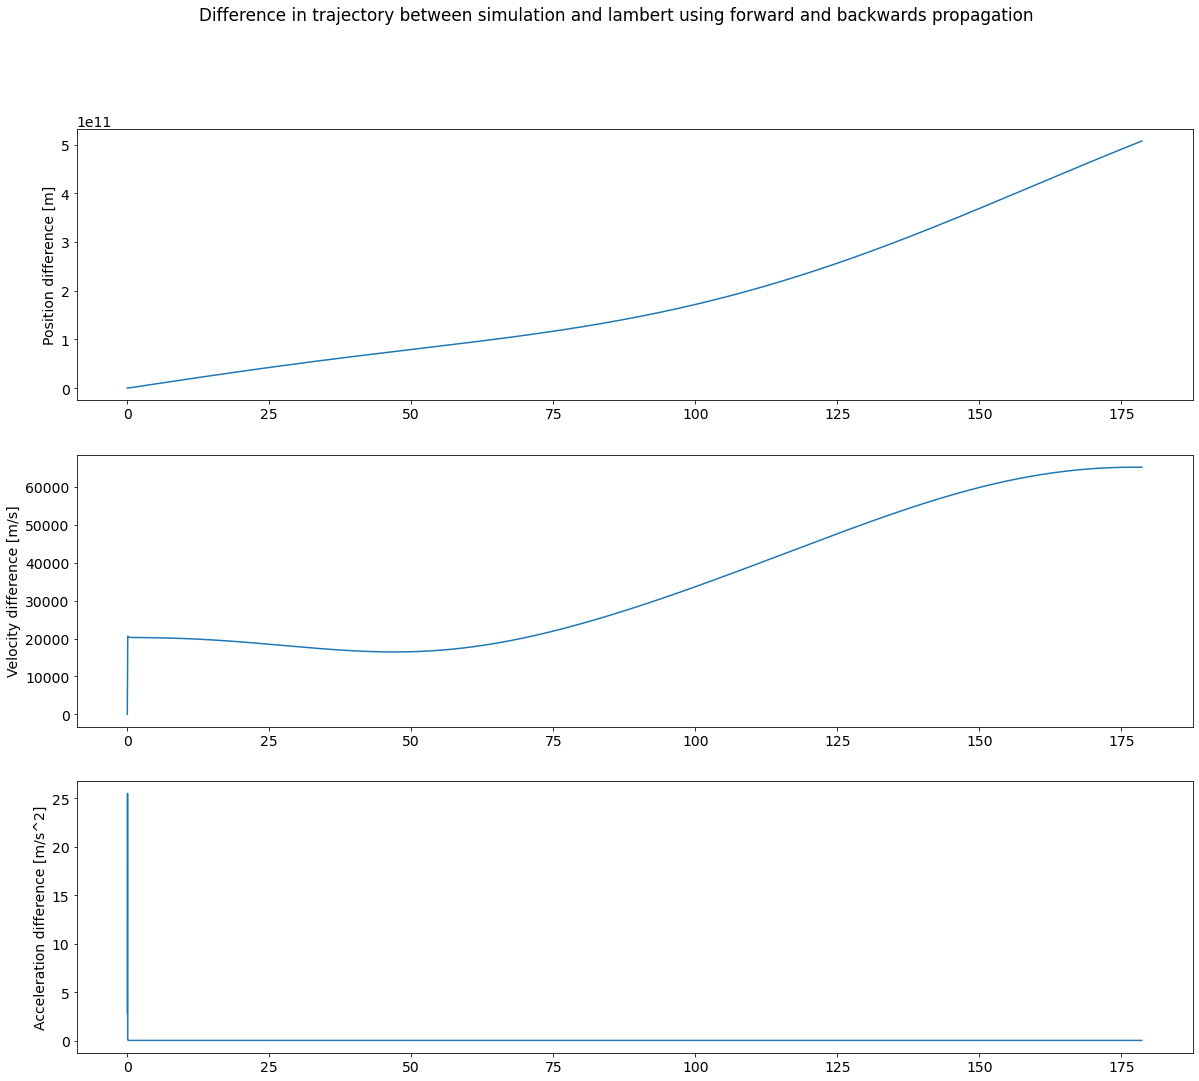

In [288]:
###########################################################################
# RUN CODE FOR QUESTION 2 #################################################
###########################################################################

current_question = 2

# Create body objects
bodies = create_simulation_bodies( )

# Create Lambert arc state model
lambert_arc_state_model = get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch)

"""
case_i: The initial and final propagation time equal to the initial and final times of the Lambert arc.
case_ii: The initial and final propagation time shifted forward and backward in time, 
respectively, by ∆t=1 hour.
case_iii: The initial and final propagation time shifted forward and backward in time,
respectively, by ∆t=2 days.

"""
cases = ['case_ii']#, 'case_ii', 'case_iii']

# Define buffer times for each case
buffer_times = [0.0, 3600.0, 2.0 * constants.JULIAN_DAY]
i = 1
# Run propagation for each of cases i-iii
for case in cases:
    
    # Compute departure and arrival time
    current_buffer_time = buffer_times[ i ]
    #i = i + 1
    # STUDENT CODE TASK (fill in ...)
    departure_epoch_with_buffer = departure_epoch + current_buffer_time
    arrival_epoch_with_buffer = arrival_epoch - current_buffer_time
    
    # Perform propagation
    # STUDENT CODE TASK (call propagation function)
    dynamics_simulator = propagate_trajectory(departure_epoch_with_buffer, arrival_epoch_with_buffer, bodies, lambert_arc_state_model, 
                     "Q2", use_perturbations = True)
    state_history = dynamics_simulator.state_history
    lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history )
    
    # For case ii, run propagation forward and backwatd from mid-point
    #if case == 'case_ii':
        
        # STUDENT CODE TASK (fill in ...)
        #mid_point_epoch = (departure_epoch_with_buffer + arrival_epoch_with_buffer)/2
        
        # Perform propagation forwards
        # STUDENT CODE TASK (call propagation function)
        #dynamics_simulator = propagate_trajectory(mid_point_epoch, arrival_epoch_with_buffer, bodies, lambert_arc_state_model, 
        #             "Q2_ii_forwards", use_perturbations = True)
        #state_history_forward = dynamics_simulator.state_history
        #lambert_history_forward = get_lambert_arc_history(lambert_arc_state_model, state_history_forward )
        #dependent_variables_for = dynamics_simulator.dependent_variable_history
        # Perform propagation backwards
        
        # STUDENT CODE TASK (call propagation function)
        #dynamics_simulator = propagate_trajectory(mid_point_epoch, departure_epoch_with_buffer, bodies, lambert_arc_state_model, 
         #            "Q2_ii_backwards", use_perturbations = True)
        #state_history_backward = dynamics_simulator.state_history
        #lambert_history_backward = get_lambert_arc_history( lambert_arc_state_model, state_history_backward)
        #dependent_variables_bac = dynamics_simulator.dependent_variable_history
    dependent_variables = dynamics_simulator.dependent_variable_history  
    font_size = 14
    plt.rcParams.update({'font.size': font_size}) 
    r_diff = []
    v_diff = []
    a_diff = []
    times  = []
    time   = state_history.keys()
    time_days = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
    for t in time:
        r_diff.append(np.linalg.norm(state_history[t][:3] - lambert_history[t][:3]))
        v_diff.append(np.linalg.norm(state_history[t][3:] - lambert_history[t][3:]))
        a_diff.append(np.linalg.norm(dependent_variables[t][:] - (((1.32712440018*10**20) / (np.linalg.norm(lambert_history[t][:3])**3))*lambert_history[t][:3])))
        times.append(t)
    
    #r_diff_for = []
    #v_diff_for = []
    #a_diff_for = []
    #time_forw  = []
    #time_for   = state_history_forward.keys()
    #time_days_for = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time_for ]
    #for t in time_for:
    #    r_diff_for.append(np.linalg.norm(state_history_forward[t][:3] - lambert_history_forward[t][:3]))
    #    v_diff_for.append(np.linalg.norm(state_history_forward[t][3:] - lambert_history_forward[t][3:]))
    #    a_diff_for.append(np.linalg.norm(dependent_variables_for[t][:] - (((1.32712440018*10**20) / (np.linalg.norm(lambert_history_forward[t][:3])**3))*lambert_history_forward[t][:3])))
    #    time_forw.append(t)
    #r_diff_bac = []
    #v_diff_bac = []
    #a_diff_bac = []
    #time_back  = []
    #time_bac   = state_history_backward.keys()
    #time_days_bac = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time_bac ]
    #for t in time_bac:
    #    r_diff_bac.append(np.linalg.norm(state_history_backward[t][:3] - lambert_history_backward[t][:3]))
    #    v_diff_bac.append(np.linalg.norm(state_history_backward[t][3:] - lambert_history_backward[t][3:]))
    #    a_diff_bac.append(np.linalg.norm(dependent_variables_bac[t][:] - (((1.32712440018*10**20) / (np.linalg.norm(lambert_history_backward[t][:3])**3))*lambert_history_backward[t][:3])))
    #    time_back.append(t)
    
    fig, (ax1, ax2, ax3) = plt.subplots( 3, 1, figsize = (20,17))
    ax1.plot(time_days, r_diff)
    ax1.set_ylabel('Position difference [m]')
    ax2.plot(time_days, v_diff)
    ax2.set_ylabel('Velocity difference [m/s]')
    ax3.plot(time_days, a_diff)
    ax3.set_ylabel('Acceleration difference [m/s^2]')
    fig.suptitle("Difference in trajectory between simulation and lambert using forward and backwards propagation" )
    #plt.savefig('Q2_middle.png')

# Question 3
## 20 points; Maximum text length: 10 lines

We will now turn our attention to modifying the trajectory, so that we arrive at the desired target when *including* perturbations. When we modify an initial state $\mathbf{x}_{0}$ or some parameter vector $\mathbf{p}$ (which contains properties of the dynamical model), the propagated state $\mathbf{x}(t)$ will change. When changing the initial state by $\Delta \mathbf{x}_{0}$ and/or a parameter vector by $\Delta \mathbf{p}$, we will denote the resulting change in numerically propagated state, as a function of time, as $\Delta {\mathbf{x}}(t)$.

For given modifications $\Delta \mathbf{x}_{0}$ and $\Delta \mathbf{p}$, the behaviour of $\Delta {\mathbf{x}}(t)$ can be obtained by directly numerically repropagating $\mathbf{x}(t)$ with the modified initial state and parameter vector, and subtracting the propagation result without these modifications. However, this can be a tedious and computationally expensive process. The matrices $\boldsymbol{\Phi}(t,t_{0})$ and $\mathbf{S}(t)$ provide a way to approximate $\Delta {\mathbf{x}}(t)$, by means of a *linearization*:

\begin{align}
\boldsymbol{\Phi}(t,t_{0})=\frac{\partial\mathbf{x}(t)}{\partial\mathbf{x}_{0}}\\
 \mathbf{S}(t)=\frac{\partial\mathbf{x}(t)}{\partial\mathbf{p}}
\end{align}

Now, we denote the linearized change in state as $\Delta \tilde{\mathbf{x}}(t)$, which we compute from:
\begin{align}
\Delta \tilde{\mathbf{x}}(t)=\boldsymbol{\Phi}(t,t_{0})\Delta \mathbf{x}_{0}+\mathbf{S}(t)\Delta\mathbf{p}\label{eq:linearizedChangeInState}
\end{align}
so that $\Delta \tilde{\mathbf{x}}(t)$ is a *linear approximation* of $\Delta {\mathbf{x}}(t)$.

For this question, we split the total propagation time into 10 equisized (in time) arcs. Using the propagation settings of the previous question (case iii), the state and variational equations for the dynamics are propagated for each arc.  For each arc $i$ (with $i$ starting at 0), the initial state $\mathbf{x}_{i}(t_{0,i})$ is set so that it corresponds exactly with the Lambert targeter state  at the corresponding time $\bar{\mathbf{x}}(t_{0,i})$. This will result in a discontinuous state history over the full transfer (since the propagation is performed in an arc-wise manner). For this question, you will compute how to make the trajectory continuous in position by applying an impulsive correction maneuver at the start of each arc, such that $\mathbf{r}_{i}=\bar{\mathbf{r}}_{i}$ at the end of each arc. 

**Answer the following questions:**

**a)** Perform the arcwise propagation. Plot the deviation $\Delta r$ of the propagated state w.r.t. the Lambert arc as a function of time over the full trajectory.

**b)** Derive a model to use the results for $\boldsymbol{\Phi}_{i}(t_{i+1},t_{i})$ to compute the change in velocity $\Delta \mathbf{v}_{i}$ needed at the beginning of each arc to ensure that the spacecraft reaches $\bar{\mathbf{r}}$ at the end of the arc. Keep the initial position of the arc constant. Show the derivation of your model. For this question, neglect linearization errors (assume $\Delta \tilde{\mathbf{x}}(t)=\Delta{\mathbf{x}}(t)$)

**c)** Modify the code, so that the initial states of each arc are modified in accordance with your calculated correction manuevers in (b).  Plot the deviation $\Delta r$ of the modified propagated state w.r.t. the Lambert arc as a function of time. Do you consider your linearized model to be applicable in this specific situation? 

<!-- **d)** The model you derived in (b) will provide a trajectory that is continuous in position, but not velocity: there are velocity discontinuities between subsequent arcs. An impulsive $\Delta V$ must be provided at each of these discontinuities, as well as at the initial time  the first arc, and final time of the last arc (to ensure $\mathbf{x}=\bar{\mathbf{x}}$ at these points. Using the assumptions and derivation of (b), derive a set of equations that will provides the total $\Delta {V}$, over the full trajectory, that are required. -->



**Add to save file 1}** <br>
Row 9: initial propagation time and Cartesian state  (arc 0). <br>
Row 10: final propagation time and Cartesian state (arc 0). <br>
Row 11: initial propagation time and Cartesian state (arc 4). <br>
Row 12: final propagation time and Cartesian state (arc 4). <br>


154.66666482308344
27318.300304374327
6.5919217494068585
27483.516985111874
2.4346613797699677
28291.985077541878
1.3457504303007026
29588.439417713438
0.7459483794766322
31330.139220017616
0.36069486327971423
33411.31184421245
0.5936522383735883
35585.514979498395
0.8673145782796179
37389.22631224984
1.7190969999898766
38219.827795506695
12.559193823443831
37754.70387211183


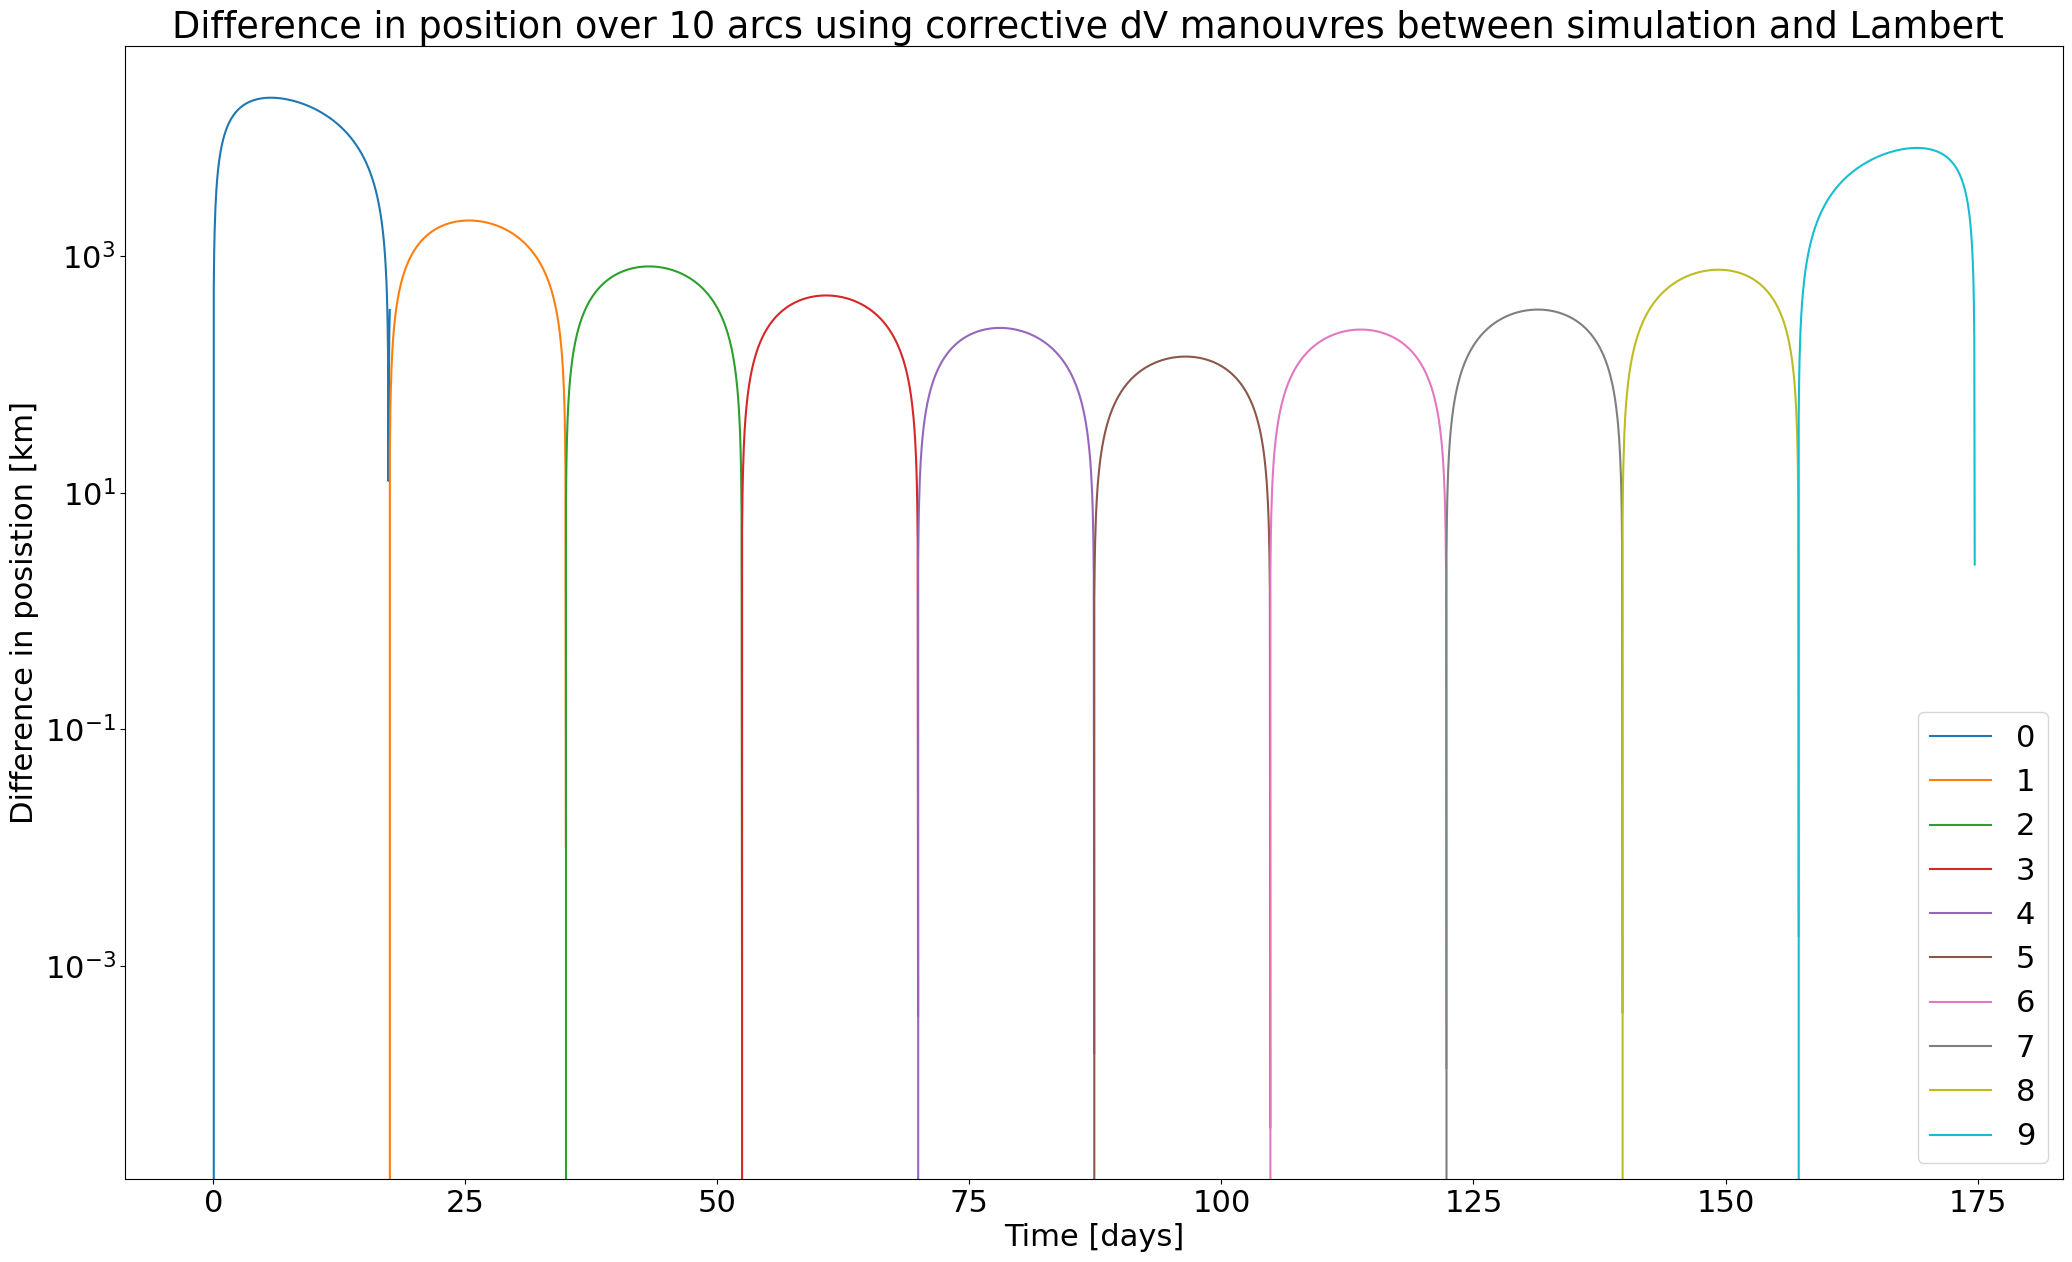

In [7]:
###########################################################################
# RUN CODE FOR QUESTION 3 #################################################
###########################################################################

current_question = 3

# Create body objects
bodies = create_simulation_bodies( )

# Create Lambert arc state model
lambert_arc_state_model = get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch)

##############################################################

# Set start and end times of full trajectory
# STUDENT CODE TASK (fill in ...)
buffer_time = 2 * constants.JULIAN_DAY
departure_epoch_with_buffer = departure_epoch + buffer_time
arrival_epoch_with_buffer = arrival_epoch -  buffer_time

# Compute number of arcs and arc length
# STUDENT CODE TASK (fill in ...)
number_of_arcs = 10
arc_length = (arrival_epoch_with_buffer - departure_epoch_with_buffer) / number_of_arcs

fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 22})
plt.ylabel('Difference in posistion [km]')
plt.xlabel('Time [days]')
plt.title('Difference in position over 10 arcs using corrective dV manouvres between simulation and Lambert ')

##############################################################
# Compute relevant parameters (dynamics, state transition matrix, Delta V) for each arc
for arc_index in range(number_of_arcs):
    
    # Compute initial and final time for arc
    # STUDENT CODE TASK (fill in ...)
    current_arc_initial_time = departure_epoch_with_buffer + arc_length * arc_index
    current_arc_final_time = current_arc_initial_time + arc_length

    ###########################################################################
    # RUN CODE FOR QUESTION 3a ################################################
    ###########################################################################
    
    # Propagate dynamics on current arc
    # STUDENT CODE TASK (call propagation function)
    dynamics_simulator =  propagate_trajectory(current_arc_initial_time, current_arc_final_time, bodies, lambert_arc_state_model, 
                     "Q3", use_perturbations = True)
    
    state_history = dynamics_simulator.state_history
    time   = state_history.keys()
    time_days = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
    
    # Retrieve Lambert arc for same epochs, and compute final difference
    lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history )

    ###########################################################################
    # RUN CODE FOR QUESTION 3d ################################################
    ###########################################################################
    
    # Solve for state transition matrix on current arc
    variational_equations_solver = propagate_variational_equations(
        current_arc_initial_time, current_arc_final_time, bodies, lambert_arc_state_model)  
    
    # Retrieve propagation resuls and compute Lambert arc history
    state_transition_matrix_history = variational_equations_solver.state_transition_matrix_history
    state_history = variational_equations_solver.state_history
    lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history )    
    final_epoch = list(state_transition_matrix_history.keys())[-1]
    
    final_state_deviation = state_history[final_epoch] - lambert_history[final_epoch]
    final_state_transition_matrix = state_transition_matrix_history[ final_epoch ]
    final_inverse_state_transition_matrix = np.linalg.inv( final_state_transition_matrix[:3,3:] )

    # Compute required velocity change at beginning of arc to meet required final state 
    # STUDENT CODE TASK: calculate initial state correction to mee arc end position requirement
    initial_state_correction = -1*np.matmul(final_inverse_state_transition_matrix, final_state_deviation[:3])
    initial_state_corrections = np.concatenate(([0,0,0], initial_state_correction))
    # Propagate with correction to initial state  
    # STUDENT CODE TASK (call propagation function). HINT: the initial state correction can be passed as an input to function
    dynamics_simulator = propagate_trajectory(current_arc_initial_time, current_arc_final_time, bodies, lambert_arc_state_model, 
                     "Q3_corrected", use_perturbations = True, initial_state_correction = initial_state_corrections)
    state_history = dynamics_simulator.state_history

    # Compute and print deviation
    final_state_deviation_after_correction = state_history[ final_epoch ] - lambert_history[ final_epoch ]    
    # Save corrected arc
    
    write_propagation_results_to_file( dynamics_simulator, lambert_arc_state_model, 
                                     "Q3_arc_" + str(arc_index) + '_corrected', output_directory)


        

    # final arc position err
    r_diff = []
    time   = state_history.keys()
    time_days = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
    for t in time:
        r_diff.append((np.linalg.norm(state_history[t][:3] - lambert_history[t][:3]))*10**-3)
    plt.plot(time_days, r_diff, label = str(arc_index))

plt.yscale('log')    
plt.legend()
#plt.show()
plt.savefig('Q3c.png')


# Question 4
## 25 points; Maximum text length:  lines

For this question, you will perform a similar analysis as in the previous question, but now using an approximate model for a low-thrust acceleration model to correct the orbit so that it reaches the start and end of the trajectory correctly. Instead of a ten-arc model, you will use a one- and two-arc model. 

In your model, you will parameterize the thrust as a constant acceleration in RSW frame for each arc. This thrust will be added to the simulation by defining a so-called 'empirical' acceleration: a constant acceleration in RSW direction. Note that, since the direction of the RSW frame changes in time, the inertial direction of this empirical acceleration will change in time. For this question, you will compute the magnitudes of these emprical accelerations, such that the trajectory meets all the required boundary conditions.

By calculating the sensitivity matrix $\mathbf{S}$ for the entries of the empirical acceleration, you will be able to calculate (approximately) the required thust under a number of different conditions. For this question, neglect linearization errors (assume $\Delta \tilde{\mathbf{x}}(t)=\Delta{\mathbf{x}}(t)$).

**Answer the following questions:**

**a)** Consider a single arc propagation for the full transfer. Derive an equation to use the results for $\mathbf{S}(t_{E})$ to compute the low-thrust acceleration in RSW frame (denote this as $\mathbf{p}$) needed to ensure that the spacecraft reaches $\bar{\mathbf{r}}(t_{E})$ at the end of the transfer. Keep the initial state of the arc constant at $\bar{\mathbf{x}}(t_{0})$. Put no constraints on the final velocity. Show the derivation of your model, starting from the equations in the lecture videos. <br>
**b)** Implement your model for question (a) in your code, and verify and argue that it works correctly (use the same value of $\Delta t$ as in question 2, case iii). Plot any quantities you need to show the correct functioning of your model.

For the next questions, you will analyze the low-thrust trajectory for a two-arc model (with each arc having equal duration). For this question, do not impose any *a priori* constraints on the absolute position or velocity at the arc splitting point (unlike in question 3, where this point was required to correspond to $\bar{\mathbf{r}}$, but do impose a constraint of continuity in position and velocity over the full trajectory (unlike in question 3, where the velocity was discontinuous between arcs).

**c)** For an arbitrary choice of constant RSW-thrust in arc 1 (denoted $\mathbf{p}_{1}$), thrust in arc 2 (denoted $\mathbf{p}_{2}$), and modification in initial velocity of arc 1 (denoted $\mathbf{v}_{i}(t_{0,1})$), derive a single equation for the change in position at the end of arc 2 (denoted $\Delta \mathbf{r}(t_{E,2})$). Write a single explicit equation for $\Delta \mathbf{r}(t_{E,2})$, in the following notation:
\begin{align}
\Delta \mathbf{r}(t_{E,2})=\mathbf{A}\begin{pmatrix} \mathbf{p}_{1}\\ \mathbf{p}_{2} \\ \Delta\mathbf{v}_{i}(t_{0,1}) \end{pmatrix}
\end{align}
and provide an explicit formulation for the matrix $\mathbf{A}$. Use the notation from the lecture slides on *Reaching the objective - Arc-wise Low-thrust*.
<br>
**d)** The equation you derived in (c) does not have a unique solution. Choose $ \Delta\mathbf{v}_{i}(t_{0,1})=\mathbf{0}$, and set $\mathbf{p}_{1}$ equal to the value of $\mathbf{p}$ you derived and computed in questions (a) and (b). Starting from the equation you derived in (c), formulate an explicit equation for $\mathbf{p}_{2}$ needed to achieve a given $\Delta \mathbf{r}(t_{E,2})$.<br>
**e)**  Implement the model you derived in question (d) in your code, such that you obtain $\mathbf{r}(t_{E,2})=\bar{\mathbf{r}}(t_{E,2})$ (*e.g.* such that the trajectory terminates on the Lambert arc). Verify that the model works correctly: show that it meets all the required constraints.

**Add to save file 1}** <br>
Row 13: final propagation time and Cartesian state (question 4b)<br>
Row 14: final propagation time and Cartesian state (question 4e)<br>

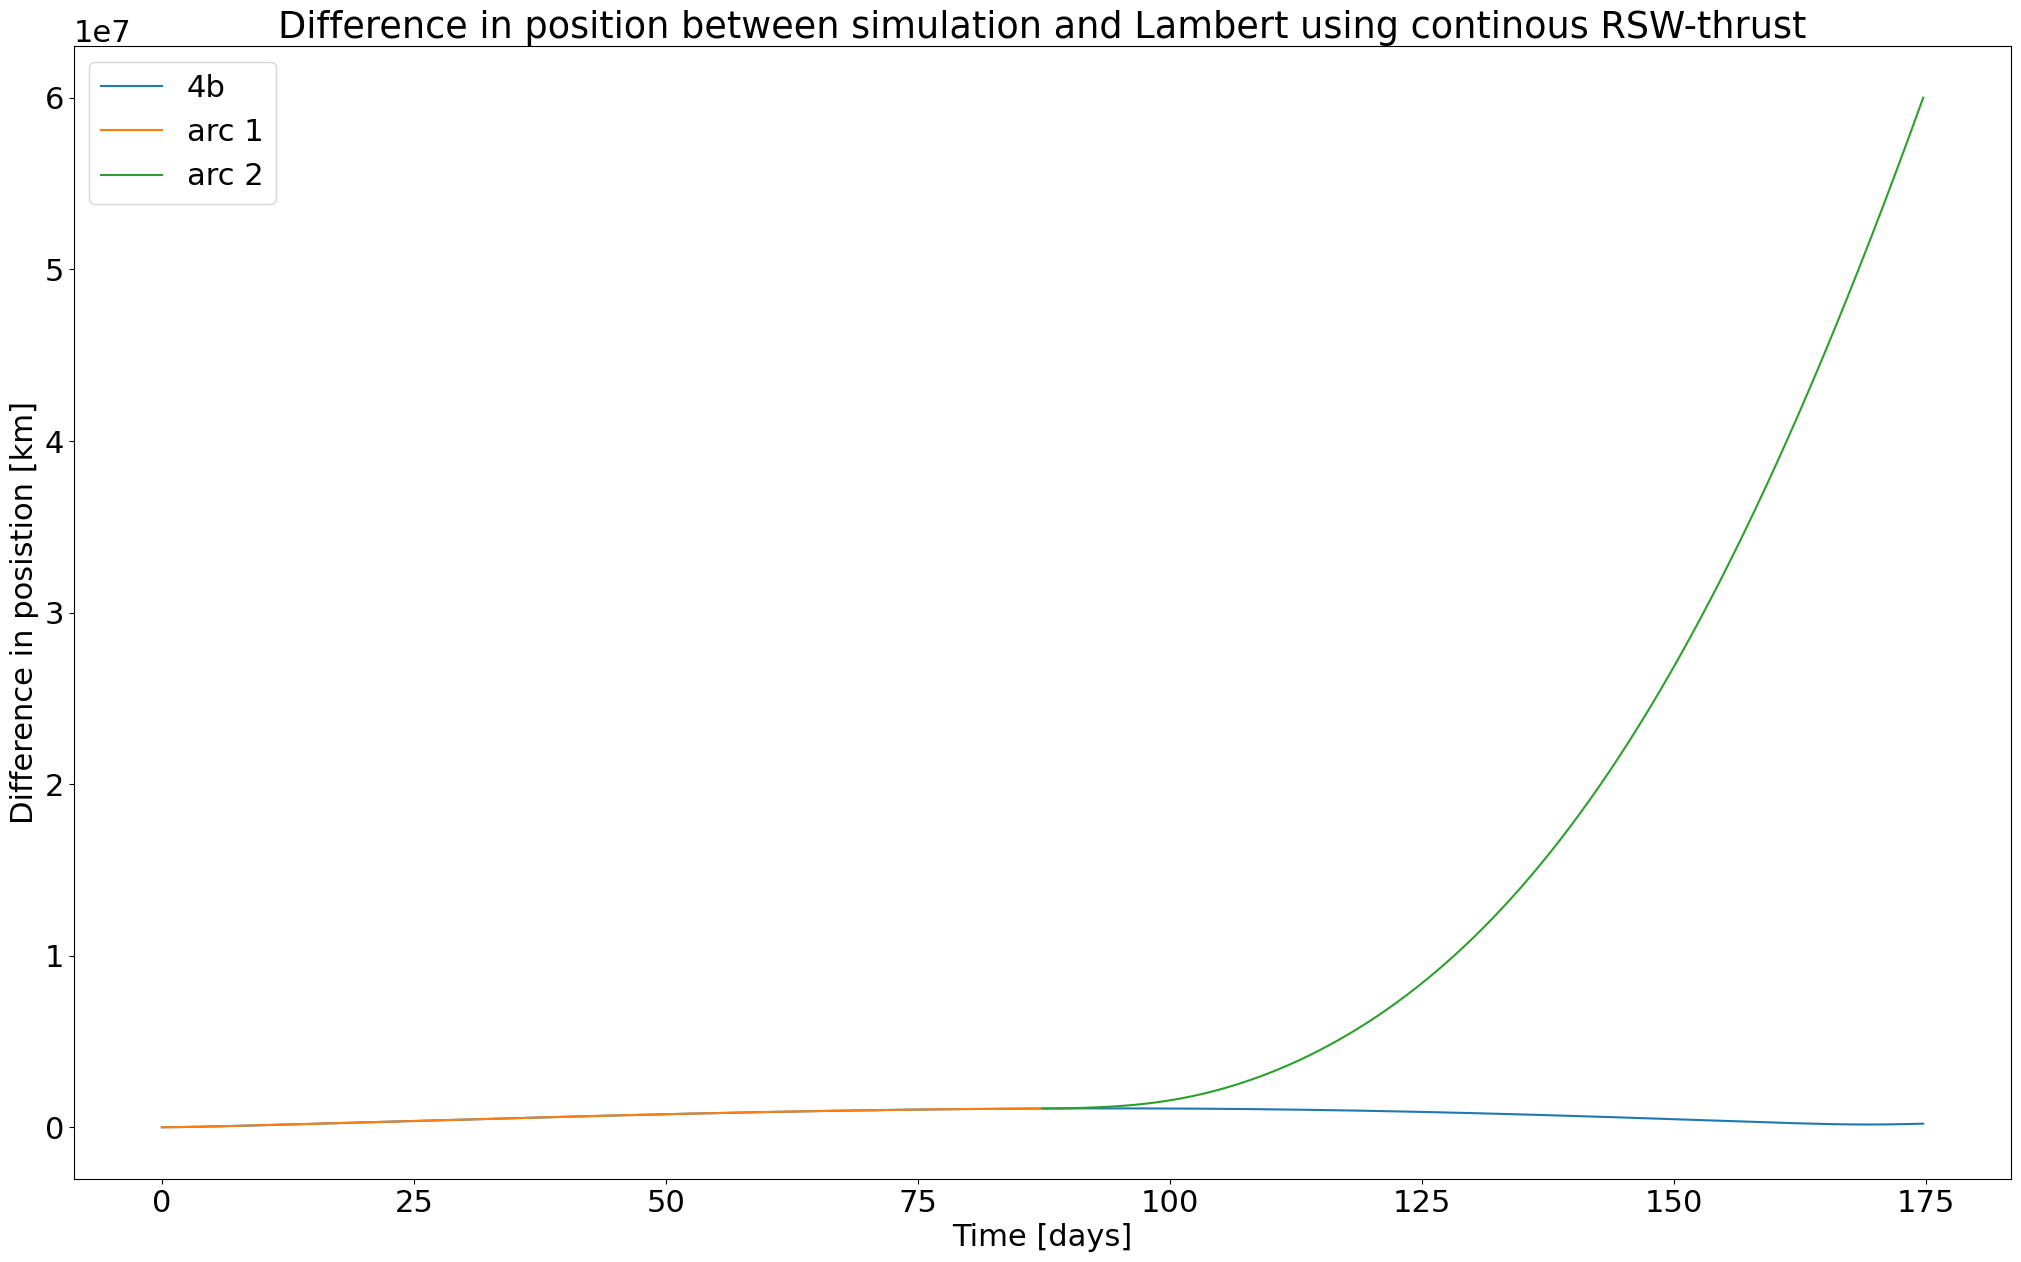

In [25]:
###########################################################################
# RUN CODE FOR QUESTION 4 #################################################
###########################################################################

current_question = 4
rsw_acceleration_magnitude = [0,0,0]

# Create body objects
bodies = create_simulation_bodies( )

# Create Lambert arc state model
lambert_arc_state_model = get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch)

###########################################################################
# RUN CODE FOR QUESTION 4b ################################################
###########################################################################

# Set start and end times of full trajectory
# STUDENT CODE TASK (fill in ...)
buffer_time = 2 * constants.JULIAN_DAY
departure_epoch_with_buffer = departure_epoch + buffer_time
arrival_epoch_with_buffer = arrival_epoch - buffer_time

# Solve for state transition matrix on current arc
variational_equations_solver = propagate_variational_equations(
    departure_epoch_with_buffer, arrival_epoch_with_buffer, bodies, lambert_arc_state_model)  

sensitivity_matrix_history = variational_equations_solver.sensitivity_matrix_history
state_history = variational_equations_solver.state_history
lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history )  
final_epoch  = list(sensitivity_matrix_history.keys())[-1]
final_sensitivity_matrix = sensitivity_matrix_history[final_epoch]
inv_final_sens = np.linalg.inv(final_sensitivity_matrix[:3,:3])


# Compute low-thrust RSW acceleration to meet required final position 
# STUDENT CODE TASK: calculate low-thrust acceleration to meet arc end position requirement
final_state_deviation = state_history[final_epoch] - lambert_history[final_epoch]
rsw_acceleration_magnitude = -1* np.matmul(inv_final_sens, final_state_deviation[:3])

# STUDENT CODE TASK (call propagation function). NOTE: Empirical acceleration with magnitude 
# rsw_acceleration_magnitude is added automatically by get_perturbed_propagator_settings function) 
dynamics_simulator = propagate_trajectory(departure_epoch_with_buffer, arrival_epoch_with_buffer, bodies, lambert_arc_state_model, 
              "Q4_b", use_perturbations = True)

state_history_case1 = dynamics_simulator.state_history
lambert_history_case1 = get_lambert_arc_history( lambert_arc_state_model, state_history_case1 ) 

r_diff_case1 = []
time   = state_history.keys()
time_days = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
for t in time:
    r_diff_case1.append((np.linalg.norm(state_history_case1[t][:3] - lambert_history_case1[t][:3]))*10**-3)

###########################################################################
# RUN CODE FOR QUESTION 4e ################################################
###########################################################################

# Compute number of arcs and arc length
# STUDENT CODE TASK (fill in ...)
number_of_arcs = 2
arc_length = ( arrival_epoch_with_buffer - departure_epoch_with_buffer ) / number_of_arcs


# Compute relevant parameters (dynamics, state transition matrix, Delta V) for each arc
for arc_index in range(number_of_arcs):
    
    # Compute initial and final time for arc
    # STUDENT CODE TASK (fill in ...)
    
    current_arc_initial_time = departure_epoch_with_buffer + arc_length * arc_index
    current_arc_final_time = current_arc_initial_time + arc_length
   
    # STUDENT CODE TASK (run arc-wise model as defined in question (e) )
    if arc_index == 0:
        dynamics_simulator = propagate_trajectory(current_arc_initial_time,current_arc_final_time , bodies, lambert_arc_state_model, 
              "Q4_arc1", use_perturbations = True)
        state_history_arc1 = dynamics_simulator.state_history
        final_epoch = list(state_history_arc1.keys())[-1]
        lambert_history_arc1 = get_lambert_arc_history( lambert_arc_state_model, state_history_arc1 ) 
        final_state_deviation_1 =  state_history_arc1[final_epoch] - lambert_history_arc1[final_epoch] 
        
        sensitivity_matrix_history = variational_equations_solver.sensitivity_matrix_history
        final_epoch  = list(sensitivity_matrix_history.keys())[-1]
        final_sensitivity_matrix_arc1 = sensitivity_matrix_history[final_epoch]
        r_diff_arc1 = []
        time   = state_history_arc1.keys()
        time_days_arc1 = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
        for t in time:
            r_diff_arc1.append((np.linalg.norm(state_history_arc1[t][:3] - lambert_history_arc1[t][:3]))*10**-3)
            

    if arc_index == 1:
        variational_equations_solver = propagate_variational_equations(
                        current_arc_initial_time, current_arc_final_time, bodies, lambert_arc_state_model)  
        # Retrieve propagation resuls and compute Lambert arc history
        state_transition_matrix_history = variational_equations_solver.state_transition_matrix_history
        state_history = variational_equations_solver.state_history
        lambert_history = get_lambert_arc_history( lambert_arc_state_model, state_history ) 
        
        final_epoch = list(state_transition_matrix_history.keys())[-1]
        final_state_deviation =  state_history[final_epoch] - lambert_history[final_epoch] 
        final_state_transition_matrix = state_transition_matrix_history[ final_epoch ]
        sensitivity_matrix_history = variational_equations_solver.sensitivity_matrix_history
        
        final_epoch  = list(sensitivity_matrix_history.keys())[-1]
        final_sensitivity_matrix_arc2 = sensitivity_matrix_history[final_epoch] 
        inv_final_sens = np.linalg.inv(final_sensitivity_matrix_arc2[:3,:3])
        
        # Calculate required rws acceleration
        w = np.matmul(final_state_transition_matrix, final_sensitivity_matrix_arc1)
        z = np.matmul(w[3:,:],rsw_acceleration_magnitude)
        dr = final_state_deviation[:3] - z
        rsw_acceleration_magnitude =1 * np.matmul(inv_final_sens, dr) # or dr
        
        # Propagate trajectory
        dynamics_simulator = propagate_trajectory(current_arc_initial_time,current_arc_final_time , bodies, lambert_arc_state_model, 
              "Q4_arc2", use_perturbations = True, initial_state_correction = final_state_deviation_1)
        
        state_history_arc2 = dynamics_simulator.state_history
        lambert_history_arc2 = get_lambert_arc_history( lambert_arc_state_model, state_history_arc2)
        r_diff_arc2 = []
        time   = state_history_arc2.keys()
        time_days_arc2 = [ t / constants.JULIAN_DAY - departure_epoch_with_buffer/ constants.JULIAN_DAY for t in time]
        for t in time:
            r_diff_arc2.append((np.linalg.norm(state_history_arc2[t][:3] - lambert_history_arc2[t][:3]))*10**-3)    
        
        

    
    
    
    
fig=plt.figure(figsize=(25,15), dpi= 100, facecolor='w', edgecolor='k')
matplotlib.rcParams.update({'font.size': 22})
plt.ylabel('Difference in posistion [km]')
#plt.yscale('log')
plt.xlabel('Time [days]')
plt.title('Difference in position between simulation and Lambert using continous RSW-thrust')
plt.plot(time_days, r_diff_case1, label = '4b')
plt.plot(time_days_arc1, r_diff_arc1, label = 'arc 1')
plt.plot(time_days_arc2, r_diff_arc2, label = 'arc 2')
plt.legend()

In [24]:
print(w[3:,:])

[[ 3.92473751e+08  7.77827364e+08 -1.97977977e+06]
 [ 6.25387394e+07  9.94805347e+07  2.84626120e+02]
 [-2.08964938e+07 -4.14220088e+07  1.45874768e+06]]


# Question 5
## 25 points; Maximum text length: 20 lines

Since the model in questions 3 and 4 for computing the influence due to a small change in state and parameters is based on a linearization, it is reasonably valid for *small* values of $\Delta \mathbf{x}_{0}$ and $\mathbf{p}$ but breaks down for larger deviations. The error $\boldsymbol{\epsilon}_{\mathbf{x}}(t)$ due to the linearization can be defined as:

\begin{align}
\boldsymbol{\epsilon}_{\mathbf{x}}(t) = \Delta \tilde{\mathbf{x}}(t) -  \Delta {\mathbf{x}}(t)
\end{align}

For this question, you will numerically investigate the limit of validity of the above linearization using $\boldsymbol{\Phi}(t,t_{0})$ (the influence of $\mathbf{S}(t)$ is not considered here), for the 10-arc model of question 3.

Determine, for arc $i=0$, and arc $i=4$, independently for each of the entries of $\Delta \mathbf{x}_{0}(=\Delta \mathbf{x}(t_{0,i}))$, how large the initial state corrections are allowed to be, before the linearization used to obtain $\Delta\tilde{\mathbf{x}}(t)$ is no longer valid.

Use the following criterion as the definition of a valid linearization:
\begin{align}
\max_{t}||\boldsymbol{\epsilon}_{\mathbf{r}}(t)||<\text{100 km}\hspace{0.5cm}\vee
\hspace{0.5cm}\max_{t}||\boldsymbol{\epsilon}_{\mathbf{v}}(t)||<\text{1 m/s}
\end{align}
where $\boldsymbol{\epsilon}_{\mathbf{r}}(t)$ and $\boldsymbol{\epsilon}_{\mathbf{v}}(t)$ denote the linearization error in position and velocity (first and last three entries of $\boldsymbol{\epsilon}_{\mathbf{x}}(t)$).

Find the minimum positive value of each entry of the initial state perturbations for arcs 0 and 4, for which the error criterion is no longer true over the full arc, each time keeping the other 5 entries of $\Delta \mathbf{x}_{0}$ fixed to zero. 

Your answer must be correct to within 25% (set up your analysis so that this is guaranteed). For instance, if the true limiting value of $\Delta {y}_{0}$ is 2.4 m, any value from 1.8 m to 3.0 m will be accepted. **Implement your model in such a way that all 12 limiting values (6 for arc $i=0$; 6 for arc $i=4$) are produced from a single run of your program.**

Explain the algorithm that you have used and implemented, explaining why the model you have set up is guaranteed to give the requested results to the required accuracy. Provide *pseudo-code* (so not a copy-paste of your code!) in your explanation.


**Add to save file 2** <br>
Matrix, 6 rows by 2 columns, permitted $\Delta \mathbf{x_0}$ (arcs 0 and 4)



In [14]:
###########################################################################
# RUN CODE FOR QUESTION 5 #################################################
###########################################################################

current_question = 5

# Create body objects
bodies = create_simulation_bodies( )

# Create Lambert arc state model
lambert_arc_state_model = get_lambert_problem_result(bodies, target_body, departure_epoch, arrival_epoch)

# Set full start and end times
buffer_time = 2.0 * constants.JULIAN_DAY
departure_epoch_with_buffer = departure_epoch + buffer_time
arrival_epoch_with_buffer = arrival_epoch - buffer_time

# Set arc length
number_of_arcs = 10
arc_length = ( arrival_epoch_with_buffer - departure_epoch_with_buffer ) / number_of_arcs

considered_arc_indices = [0, 4]

for arc_index in considered_arc_indices:
    
    # Compute start and end time for current arc
    current_arc_initial_time = departure_epoch_with_buffer + arc_index * arc_length
    current_arc_final_time = departure_epoch_with_buffer + ( arc_index + 1 ) * arc_length

    # Get propagator settings for perturbed forward arc
    arc_initial_state = lambert_arc_state_model.get_cartesian_state( current_arc_initial_time )
    propagator_settings = get_perturbed_propagator_settings( bodies, arc_initial_state, current_arc_final_time )
    
    # Set integrator settings
    integrator_settings = propagation_setup.integrator.runge_kutta_4(
        current_arc_initial_time, fixed_step_size
    )
    
    ###########################################################################
    # PROPAGATE NOMINAL TRAJECTORY AND VARIATIONAL EQUATIONS ##################
    ###########################################################################
    
    parameters_for_which_to_compute_sensitivity = get_sensitivity_parameter_set( propagator_settings, bodies, 
                                                                                target_body)

    variational_equations_simulator2= estimation_setup.SingleArcVariationalEquationsSolver(
         bodies, integrator_settings, propagator_settings, parameters_for_which_to_compute_sensitivity, integrate_on_creation=1 )
    
    state_transition_result = variational_equations_simulator2.state_transition_matrix_history
    nominal_integration_result = variational_equations_simulator2.state_history
    
        
    # TODO: Retrieve nominal initial state value (e.g. initial state with Delta x_0 = 0)
    initial_epoch = list(state_transition_result.keys())[0]
    original_initial_state = nominal_integration_result[ initial_epoch ]
    
    ###########################################################################
    # START ANALYSIS ALGORITHM FOR QUESTION 4 #################################
    ###########################################################################
    
    # This vector will hold the maximum permitted initial state perturbations for which the linearization 
    # is valid (for the current arc. The vector is initialized to 0, and each of its 6 entries is computed 
    # in the 6 iterations of the coming for loop (that runs over the iteration variable 'entry')
    permitted_perturbations = np.array([0,0,0,0,0,0])
    
    # Iterate over all initial state entries
    for entry in range(6):
        
        # STUDENT CODE TASK: Define (iterative) algorithm to compute current entry of 'permitted_perturbations'
        # General structure: define an initial state perturbation (perturbed_initial_state variable),
        # compute epsilon_x (see assignment), and iterate your algorithm until convergence
        initial_state_perturbation = np.array([0,0,0,0,0,0])
        initial_state_pert = 0
        if entry <=2:
            initial_state_pert = 10**6 
            initial_step_size = 10**6
        if entry >2:
            initial_step_pert = 10
            initial_step_size = 10
        epsilon_r_new = 0
        epsilon_v_new = 0
        w = True
        
        while w == True:
            while epsilon_r_new <100000 and epsilon_v_new<1:
                # It aint pretty or quick, but it works i think

                # STUDENT CODE TASK: define initial state perturbation for current iteration
                initial_state_perturbation = np.array([0,0,0,0,0,0])
                initial_state_perturbation[entry] = initial_state_pert 
                # Reset propagator settings with perturbed initial state
                perturbed_initial_state = arc_initial_state + initial_state_perturbation
                propagator_settings.reset_initial_states( perturbed_initial_state )

                # Create simulation object and propagate dynamics with perturbed initial state
                dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, propagator_settings)

                # Retrieve state history computed directly from perturbed initial state
                integration_result = dynamics_simulator.get_equations_of_motion_numerical_solution()

                # Compute epsilon_x
                epsilon = []
                mag_epsilon = []
                time = nominal_integration_result.keys()
                for t in time:
                    delta_x_tilde = np.matmul(state_transition_result[t], initial_state_perturbation)
                    delta_x       = integration_result[t] - nominal_integration_result[t]
                    epsilon.append(delta_x_tilde - delta_x)
                    mag_epsilon.append(np.linalg.norm(delta_x_tilde - delta_x))

                index = mag_epsilon.index(max(mag_epsilon))
                epsilon_r_old = epsilon_r_new
                epsilon_v_old = epsilon_v_new

                epsilon_r_new = np.linalg.norm(epsilon[index][:3]) 
                epsilon_v_new = np.linalg.norm(epsilon[index][3:])

                if (epsilon_r_new - epsilon_r_old) + epsilon_r_new > 100000:
                    initial_step_size = initial_step_size * 10**-1
                elif (epsilon_v_new - epsilon_v_old) + epsilon_v_new > 1:
                    initial_step_size = initial_step_size * 10**-1

                initial_state_pert = initial_state_pert + initial_step_size

            #initial_state_pert_plus = initial_state_pert/0.75
            #initial_state_pert_min =  initial_state_pert/1.25
            q = 0
            for i in [0.75, 1.25]:
                initial_state_pert_new = initial_state_pert/i
                perturbed_initial_state = arc_initial_state + initial_state_pert_new
                propagator_settings.reset_initial_states( perturbed_initial_state )

                # Create simulation object and propagate dynamics with perturbed initial state
                dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
                    bodies, integrator_settings, propagator_settings)

                # Retrieve state history computed directly from perturbed initial state
                integration_result = dynamics_simulator.get_equations_of_motion_numerical_solution() 
                epsilon = []
                mag_epsilon = []
                time = nominal_integration_result.keys()
                for t in time:
                    delta_x_tilde = np.matmul(state_transition_result[t], initial_state_perturbation)
                    delta_x       = integration_result[t] - nominal_integration_result[t]
                    epsilon.append(delta_x_tilde - delta_x)
                    mag_epsilon.append(np.linalg.norm(delta_x_tilde - delta_x))

                index     = mag_epsilon.index(max(mag_epsilon))
                epsilon_r = np.linalg.norm(epsilon[index][:3]) 
                epsilon_v = np.linalg.norm(epsilon[index][3:])  
                #print(epsilon_r - 100000,epsilon_r_new-100000 )
                if (epsilon_r -100000) > (epsilon_r_new-100000) and (epsilon_v-1) > (epsilon_v_new-1) :
                    q = q + 1
                else:
                    initial_state_pert = initial_state_pert - initial_step_size
                    initial_step_size  = initial_step_size * 0.1
                
            if q ==2:
                w = False
                
                
        # Run it again computation whith these perturbations if result is better then both okay
        # if not well fock, change to smaller step and a close initial state pert
        # while True/false thingy. 
        
                

        
            
            
            
            
        permitted_perturbations[entry] = initial_state_pert
        
    
    print("Permitted perturbations: ", arc_index, np.transpose( permitted_perturbations ) )



Permitted perturbations:  0 [14657110 11754561 15694292      118       94      124]
Permitted perturbations:  4 [416411000 316159110 390949595       660       477       618]


# Submission and reporting instructions


**Reporting instructions - formulating equations of motion**

When asked to explicitly write out one or more accelerations

<ul>
    <li> Follow the notation from the lecture notes </li>
    <li> Use the following indices: $S$ for Sun, $E$, $V$ and $M$ for Earth, Venus and Mars, respectively, and $p$ for the spacecraft. </li>
    <li> Use a comma to separate indices as you see fit (spacecraft position w.r.t. the Sun can be written as $\mathbf{r}_{S,p}$ or $\mathbf{r}_{Sp}$). </li>
    <li> There is no need to specify the frame orientation of any of the vectors. All are assumed to be in a frame with inertial orientation. </li>
    <li> When denoting separate accelerations, always denote the body $B$ exerting, and body $A$ undergoing, the acceleration with $\mathbf{a}_{_{BA}}$. </li>
    <li> When writing out a single acceleration in terms of positions $\mathbf{r}$, always first write the total relative positions $\mathbf{r}_{_{CD}}$ as used by the acceleration model. Expand the positions further as you see fit in next steps. </li>
    <li> When writing a position $\mathbf{r}_{_{CD}}$ that is partly retrieved from the environment (if any), and  where part of the vector is numerically propagated, split the separate contributions (in a second step after the previous point). For instance, if  $\mathbf{r}_{_{ED}}$ is propagated, and $\mathbf{r}_{_{CD}}$ is used in the acceleration, write $\mathbf{r}_{_{CD}}=\mathbf{r}_{_{CE}}+\mathbf{r}_{_{ED}}$. </li>
</ul>

### Reporting instructions - change in position

When asked to plot/compute the change in total position between two simulation results $\mathbf{r}_{1}(t)$ and $\mathbf{r}_{2}(t)$. The change in total position is to be computed as $||\Delta \mathbf{r}(t)||= ||\mathbf{r}_{2}(t)-\mathbf{r}_{1}(t)||$

### Reporting instructions - figures

When using figures, take the following guidelines into account:

<ul>
    <li> Any text (legend, axis labels etc.) should be sufficiently large so as to be legible when printed on A4 paper. </li>
    <li>Each curve should be distinguishable in your plots. </li>
    <li>Adjust the scale (e.g. linear vs. logarithmic) of your plots as needed to interpret your data.</li>
    <li>Make efficient use of space for graphs and plots. Whenever possible and legible: plot multiple curves (e.g. for different runs and/or elements) in a single figure. </li>
    <li>All figures must be complete (including axis labels, legend, caption, etc.)</li>
</ul>

Points will be deducted for unreadable figures, or figures that do not clearly show information that you refer to in your discussion.

### Reporting instructions - cover page

The cover page of each report **must contain**:

<ul>
    <li> A link to the private Github repository containing the source code and output files (see below). </li> 
    <li> The names of any people with whom you cooperated (if any) </li>
    <li> The time spent per question </li>
</ul>

If any of these points are not present on your cover page, points will be deducted.


### Reporting instructions - general

Follow the provided limitations on the length of the text that you use (this excludes figures, tables and equations). Answers longer than the imposed limit will not be read beyond this limitation. Example: if the imposed limitation is 10 lines, and you write 15, we will grade the answer based **only** on the first 10 lines.

You are free to work together with your fellow students, but are required to write your own code and report. Copying/pasting from each others report/code is not accepted, and can lead to the case being referred to the Faculty Board of Examiners.

### Support instructions

In case of any questions, there are a number of options for support:

<ul>
    <li> For issues with the installation, unit tests, or the general use of Tudat, please post an issue on Github. When posting an issue, first browse through existing issues. If your problem is raised in an open issue, post in {that} issue instead of opening a new one. Note the operating system you are using. </li>
    <li> In case of questions specific to the assignments, use the Brightspace forum. As with Github, go through existing posts before opening a new one. Do no publicly post your code, or other information that provides direct answers to the questions. </li>
    <li> In-person support and Q$\&$A is also available during working lectures and open office hours. See Brightspace calendar for time and location. </li>
</ul>

See Brightspace (Course Information $\rightarrow$ Staff and Support) for details on what to prepare when asking for support.

### Submission instructions

You will not be graded on your coding style. Submission of the reports and output files is to be done through Brightspace. **Deadline for submission is January 17 2021 23:59 CET** and can also be found on Brightspace. For late submissions, 1 point (out of a total of 10) will be subtracted {per day}. So, when handing in the report $x$ days late, $\lceil{x}\rceil$ points will be deducted. *If* you have $g$ grace days left: when handing in the report $x$ days late, $\lceil{x-g}\rceil$ points will be deducted.

Submission of your final code and results files will be done through Github. Ensure that **you only commit to a private repository**. Instructions on pushing code to Github can be found in:

https://tudat-space.readthedocs.io/en/latest/_src_use_of_tools/github.html

See below for the exact files and filenames to submit:

## *Failure to comply exactly with the requirements for file contents and naming set out below will result in point deductions.*



Instructions on how to commit code to your repository is given at https://tudat-space.readthedocs.io/en/latest/_src_use_of_tools/github.html. In addition to the report, for this assignment you will  submit:


* This notebook (which can be run directly without modifications to reproduce your results). Commit and push this file to your private GitHub repository (in the $\texttt{Assignment2/}$ directory).
* A text file containing $\textbf{only}$ the initial or final time (column 1) and Cartesian states (as a row vector; columns {2-7}) from a number of your simulations, to at least 8 digits of precision. The specific simulations for which you are to save the time/state, and the row in which you are to save them are indicated in the questions. Name the file `CartesianResults_AE4868_2020_2_YYYYYYY.dat`, where YYYYYYY is your student number. Upload this file to Brightspace.
* A text file containing $\textbf{only}$ the 6x2 matrix of permitted $\Delta \mathbf{x_0}$ for question 5. Name the file `Question5_Results_AE4868_2020_2_YYYYYYY.dat`, where YYYYYYY is your student number.  Upload this file to Brightspace. 


        
## *Failure to comply exactly with the requirements for file contents and naming set out below will result in point deductions.*